In [8]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
#Loading model
import sys
import os
import torch
# Get the current script's directory
current_directory = os.getcwd()
print(current_directory)
library_directory = os.path.abspath(os.path.join(current_directory, 'torchVersion', 'BLIP'))
sys.path.append(library_directory)
from models.blip_vqa import blip_vqa

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'

image_size = 480
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model = model.to(device)

e:\10mociclo\FoundationModels\Multiple-choice-VQA\FineTuningBLIP
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


**Dataset**

In [10]:
import sys
sys.path.append('../')  # Adjust the path accordingly
from VQA_Dataset_BLIP import VQA_Dataset_TorchVersion

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = VQA_Dataset_TorchVersion()
dataset.load_all(length=20, device=device)

Preprocessing Images: 100%|██████████| 20/20 [00:00<00:00, 44.38it/s]


**Test-train split**

In [11]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.9)
val_size = int(len(dataset)*0.05)
test_size = int(len(dataset))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Train size:  18
Test size:  1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


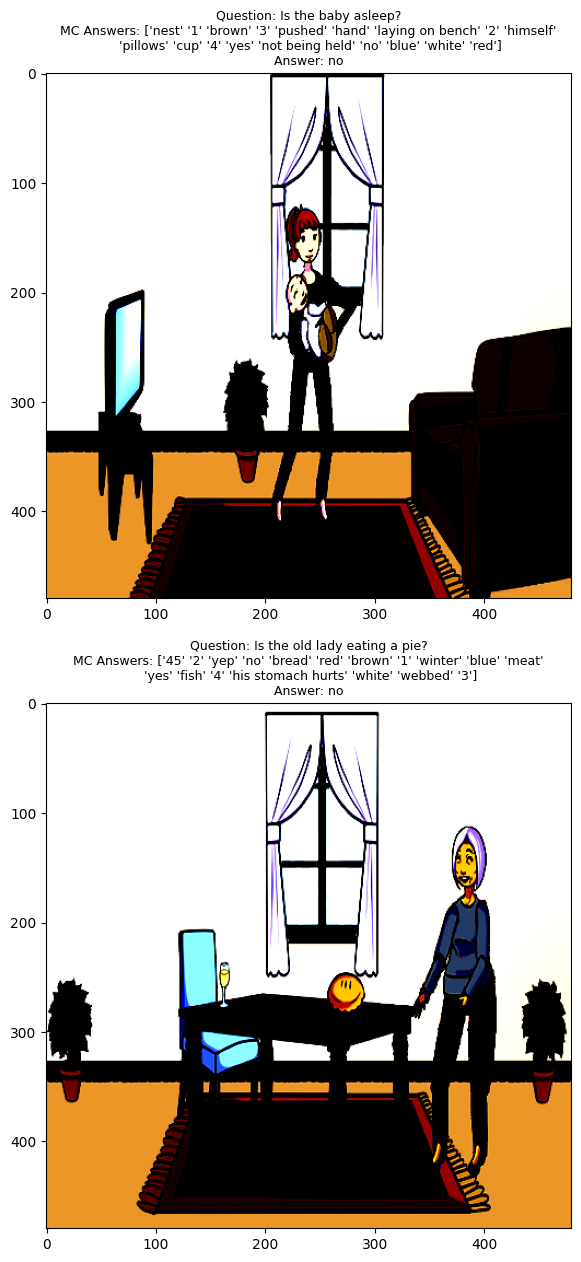

In [12]:
#Checking data
fig=plt.figure(0, (28, 15))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        multiple_answers = np.array(element[2]).T[i]
        ax.imshow(np.transpose(element[0][i].squeeze(0).cpu(), (1, 2, 0))) #Converting to matplotlib format
        ax.set_title("Question: "+str(element[1][i])+"\nMC Answers: "+str(multiple_answers)+"\nAnswer: "+str(element[3][i]), fontsize=9)
    break

**Cosine similarity of output encoding and multiple answers encoding (BLIP)**

In [13]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for element in pbar:
            for i in range(batch_size):       
                question = str(element[1][i])
                image = element[0][i]
                
                with torch.no_grad():
                    answer = model(image, question, train=False, inference='generate')
                    predicted_answer = answer[0]
                    correct_answer = str(element[3][i])
                    print(f"Predicted: {predicted_answer}, Correct: {correct_answer}")  
                    correct += (correct_answer==predicted_answer)
            break
    correct /= size
    return 100*correct
eval(train_dataloader, model)

  0%|          | 0/9 [00:06<?, ?it/s]


RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 0

In [ ]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for element in pbar:
            for i in range(batch_size):       
                question = str(element[1][i])
                multiple_answers = list(np.array(element[2]).T[i])
                multiple_answers_tokenizer = model.tokenizer(multiple_answers, padding='longest', truncation=True, max_length=35,return_tensors="pt").to(device)
                image = element[0][i]
                
                with torch.no_grad():
                    idx = model(image, question, answer = multiple_answers_tokenizer, train=False, inference='rank', k_test=2).item()
                    predicted_answer = multiple_answers[idx]
                    correct_answer = str(element[3][i])
                    #print(f"Predicted: {predicted_answer}, Correct: {correct_answer}")  
                    correct += (correct_answer==predicted_answer)
    correct /= size
    return 100*correct
eval(train_dataloader, model)#61.4815%

  0%|          | 0/270 [00:00<?, ?it/s]


0.1851851851851852